In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, _), (_, _) = mnist.load_data()

# Normalize to [-1,1]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # shape = (28,28,1)

img_shape = (28,28,1)
latent_dim = 100

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_generator(latent_dim):
    model = Sequential()

    # Fully connected layer -> reshape
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Upsample to 28x28
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Final Conv Layer
    model.add(Conv2D(1, kernel_size=3, padding="same", activation="tanh"))

    return model

In [4]:
def build_discriminator(img_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model


In [5]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

generator = build_generator(latent_dim)

# Combined GAN model
from tensorflow.keras.models import Model
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

dcgan = Model(z, validity)
dcgan.compile(loss="binary_crossentropy", optimizer=optimizer)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history = {"d_loss": [], "d_acc": [], "g_loss": []}

def train(epochs=10000, batch_size=64, save_interval=2000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(1, epochs+1):
        # ---- Train Discriminator ----
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = dcgan.train_on_batch(noise, real)

        # ---- Store history ----
        history["d_loss"].append(d_loss[0])
        history["d_acc"].append(d_loss[1])
        history["g_loss"].append(g_loss)

        # ---- Print progress ----
        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

        # ---- Save sample images ----
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [7]:
def save_imgs(epoch, examples=25):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    gen_imgs = 0.5 * gen_imgs + 0.5  # rescale to [0,1]

    plt.figure(figsize=(5,5))
    for i in range(examples):
        plt.subplot(5,5,i+1)
        plt.imshow(gen_imgs[i,:,:,0], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [8]:
def plot_history():
    plt.figure(figsize=(15,5))

    # Losses
    plt.subplot(1,3,1)
    plt.plot(history["d_loss"], label="Discriminator Loss")
    plt.plot(history["g_loss"], label="Generator Loss")
    plt.title("Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history["d_acc"], label="Discriminator Accuracy")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Combined Loss comparison
    plt.subplot(1,3,3)
    plt.plot(history["d_loss"], label="D Loss")
    plt.plot(history["g_loss"], label="G Loss")
    plt.title("Generator vs Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


500 [D loss: 1.1257, acc: 29.49] [G loss: 0.2579]
1000 [D loss: 1.2158, acc: 29.29] [G loss: 0.2079]


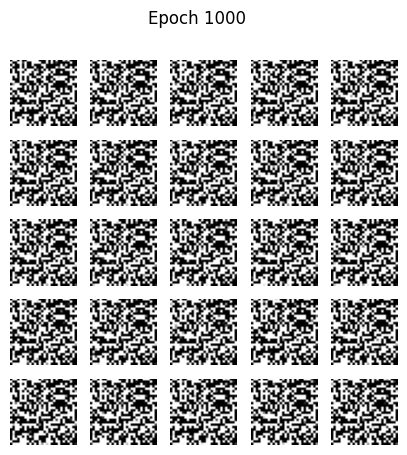

In [ ]:
train(epochs=5000, batch_size=64, save_interval=1000)
plot_history()